In [8]:
import os
import numpy as np
import numpy.linalg as npl
import random

import orix
from diffpy.structure import Atom, Lattice, Structure
from orix import data, io, plot
from orix.io import load, save
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Misorientation, Orientation, Rotation, symmetry
from orix.sampling import get_sample_fundamental
from orix.vector import Vector3d

import scipy
from scipy import stats
from scipy.spatial.transform import Rotation as R
from sklearn.neighbors import KernelDensity

In [2]:
# Defining our rotations grid..

pg432 = symmetry.O
resolution2 = 1

rot_quat = get_sample_fundamental(resolution2, point_group=pg432, method="quaternion")
ori_quat_uniform = Orientation(rot_quat, symmetry=pg432)

# Quaternion is a 4D normalized vector.

In [3]:
# Loading in our data from .ang files

target = os.path.abspath(os.path.join(
    'sdss_ferrite_austenite.ang'
))

# Read each column from the file
euler1, euler2, euler3, x, y, iq, dp, phase_id = np.loadtxt(target, unpack=True)

# Create a Rotation object from Euler angles
euler_angles = np.column_stack((euler1, euler2, euler3))
rotations = Rotation.from_euler(euler_angles)

# Create a property dictionary
properties = dict(iq=iq, dp=dp)

# Create unit cells of the phases
structures = [
    Structure(
        title="austenite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.360, 0.360, 0.360, 90, 90, 90)
    ),
    Structure(
        title="ferrite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.287, 0.287, 0.287, 90, 90, 90)
    ),
]
phase_list = PhaseList(
    names=["austenite", "ferrite"],
    point_groups=["432", "432"],
    structures=structures,
)

# Create a CrystalMap instance
xmap = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)

xmap.phases[1].name = "austenite"
xmap.phases[2].name = "ferrite"
Aust = xmap['austenite']

In [4]:
def generate_random_quaternion(size=1):
    '''
    This function generates an arbitrary number of quaternions.
    
    Quaternions are 4D normalized vectors.
    
    We will generate these quaternions by sampling from a uniform distribution,
    and normalizing the vector. Then, we will append the normalized quaternion
    to the output, `quaternions`.

    Inputs:
    --------------
    size : int
        Number of quaternions to generate.
    

    Outputs:
    --------------
    quaternions : list
        Generated quaternions.


    Dependencies:
    --------------
    import numpy as np
    import numpy.linalg as npl


    Author(s) (Remove during code review):
    --------------
    Adam Pilchak
    Rohan Casukhela
    '''
    quaternions = []
    for element_0 in range(size):
        quaternion = np.random.randint(-10000, 10000, 4)
        quaternion = npl.norm(quaternion)
        quaternions.append(quaternion)

    return quaternions

In [5]:
# Defining our rotations of our grid and our data..

data_quat = Aust.orientations
data_xyz = R.from_quat(data_quat.data).as_mrp()
sp_ori = R.from_quat(data_quat.data)
o2 = R.from_quat(ori_quat_uniform.data)

In [6]:
def generate_ODF(orientations, rotations, bin_number=100, sigma=1, method="fast"):
    '''
    Generates ODF over rotations, given orientations. Only "Fast" method is
    supported, currently.

    The ODF is generated by first creating a histogram with forced bin numbers.
    Second, the histogram is convolved with a Gaussian kernel with fixed variance,
    sigma.

    Inputs:
    --------------
    orientations : np.array
        This is an array of orientations, in quaternion space.

    rotations : np.array
        This is an array of the rotations with some pre-defined resolution,
        also in quaternion space.

    bin_number : int
        Number of bins in one dimension (for a total of three, X, Y, and Z)
        we'd like to create the histogram over. (MUST BE NON-NEGATIVE)

    sigma : float
        Variance of the Gaussian kernel when we blur the histogram. (MUST BE
        GREATER THAN OR EQUAL TO ZERO))

    ***method*** : str
        "fast" ONLY for now, eventually "accurate". WARNING:
        Currently only "fast" (AND INACCURATE) ODF generation is supported.

    
    Outputs:
    --------------
    odf : np.array
        This array should contain the values of the smoothed histogram
        that we want.

    Dependencies:
    --------------
    from numpy import histogramdd
    from scipy.spatial.transform import Rotation as R
    from scipy.ndimage import gaussian_filter


    '''
    ori_xyz = R.from_quat(orientations.data).as_mrp()
    
    hist, edges = histogramdd(ori_xyz, bin_number)
    
    odf = gaussian_filter(hist, sigma=sigma)

    return odf


def plot_stuff():
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(int(np.sqrt(bin_number)), int(np.sqrt(bin_number)), figsize=(15,15), )
    layer_index = 0
    for elem0 in range(int(np.sqrt(bin_number))):
        for elem1 in range(int(np.sqrt(bin_number))):
            axs[int(elem0), int(elem1)].plot(hist[:, :, int(layer_index)])
            layer_index += 1
    return None



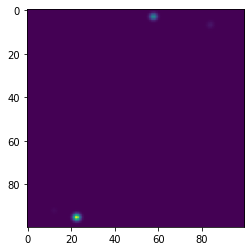

In [28]:
import matplotlib.pyplot as plt
plt.imshow(gaussian_convolution[:,:, 1])

`data_quat` is our data, `ori_quat_uniform` is our grid.

What we need to do is, for each point on the grid, to evaulate the kernel at each 
of the elements in `data_quat`.

So, pick a kernel returning a half-width and kernel function.

In [14]:
KernelDensity(kernel = 'gaussian')
kde_sk = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde_sk.fit(data_quat.data)
y_sk = np.exp(kde_sk.score_samples(ori_quat_uniform.data))

array([[ 0.92718385],
       [ 0.37460659],
       [ 0.        ],
       ...,
       [ 0.3362215 ],
       [-0.19850813],
       [-0.28349899]])